<a href="https://colab.research.google.com/github/RoshanYSingh23/EV_Charging_Schedules_Using_Convex_Optimization/blob/main/convex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import bisect

In [25]:
# Load data for the price vector
df_price    = pd.read_excel('/content/price.xlsx')
p_raw       = df_price['P(T)'].iloc[:24].values
p           = p_raw.copy()
if p_raw.mean() > 100: p *= 0.012
if p.mean()    >   1: p /= 100

# Load the file for the E_req and P_max values
df_sessions = pd.read_csv('/content/station_data_dataverse.csv')
demo        = df_sessions.iloc[0]
E_req       = float(demo['kwhTotal'])
P_max       = demo.get('maxPowerKw', 7.2) # 7.2 W is an accepted value, and ideally, we should use this
alpha       = 0.0025

# Print initial parameters
print("Price p:", np.round(p,3))
print(f"E_req = {E_req:.3f}, P_max = {P_max:.3f}, alpha = {alpha}")




Price p: [0.241 0.226 0.217 0.217 0.234 0.259 0.323 0.395 0.472 0.645 0.471 0.465
 0.417 0.358 0.332 0.338 0.364 0.324 0.385 0.387 0.313 0.302 0.243 0.242]
E_req = 7.780, P_max = 7.200, alpha = 0.0025


In [27]:
# KKT optimum
def kkt_full(p, E, Pm, alpha, tol=1e-8):
    def sum_energy(lmbda): return np.clip((lmbda - p)/(2*alpha), 0, Pm).sum() - E
    lo, hi = p.min()-1, p.max()+2*alpha*Pm+1
    lambda_k = bisect(sum_energy, lo, hi, xtol=tol)
    x = np.clip((lambda_k - p)/(2*alpha), 0, Pm)
    return lambda_k, x

lambda_kkt, x_kkt = kkt_full(p, E_req, P_max, alpha)
C_kkt = (p*x_kkt + alpha*x_kkt**2).sum()

# Print KKT results
print("\n--- KKT solution ---")
print("lambda_k* =", lambda_kkt)
print("x* =", np.round(x_kkt,3))
nu = np.maximum(-(lambda_kkt - p)/(2*alpha), 0)
mu = np.maximum((lambda_kkt - p)/(2*alpha) - P_max, 0)
print("nu =", np.round(nu,3))
print("mu =", np.round(mu,3))
print(f"KKT cost = {C_kkt:.6f}\n")


--- KKT solution ---
lambda_k* = 0.2330582680696861
x* = [0.    1.337 3.162 3.282 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
nu = [ 1.528  0.     0.     0.     0.276  5.109 18.001 32.348 47.878 82.451
 47.632 46.335 36.716 25.049 19.748 21.071 26.116 18.208 30.361 30.791
 16.078 13.773  2.015  1.69 ]
mu = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
KKT cost = 1.756815



In [28]:
# Projection helper function
def project(y, E, Pm, tol=1e-8):
    def f(theta): return np.clip(y - theta, 0, Pm).sum() - E
    lo, hi = y.min()-Pm, y.max()
    θ = bisect(f, lo, hi, xtol=tol)
    return np.clip(y - θ, 0, Pm)

In [29]:
# Projected Gradient Descent
def pgd(p, E, Pm, alpha, lr0, iters=200):
    x = np.full_like(p, E/len(p)); errs=[]
    for k in range(1, iters+1):
        lr = lr0/np.sqrt(k)
        g = p + 2*alpha*x
        x = project(x - lr*g, E, Pm)
        errs.append(abs((p*x + alpha*x**2).sum() - C_kkt))
    return x, errs


In [30]:
#Accelerated Gradient Descent
def agd(p, E, Pm, alpha, lr=None, iters=200):
    if lr is None: lr = 1/(4*alpha)
    x = y = np.full_like(p, E/len(p)); t=1; errs=[]
    for _ in range(iters):
        g = p + 2*alpha*y
        x_new = project(y - lr*g, E, Pm)
        t_new = (1 + np.sqrt(1 + 4*t*t)) / 2
        y = x_new + ((t - 1)/t_new)*(x_new - x)
        x, t = x_new, t_new
        errs.append(abs((p*x + alpha*x**2).sum() - C_kkt))
    return x, errs


In [31]:

# Tune learning rates for PGD and EGD
pgd_lrs = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0, 5.0, 20.0] # Added 20.0, because, surprisingly, it gave the best answer for pgd
best_pgd = min(pgd_lrs, key=lambda lr: pgd(p, E_req, P_max, alpha, lr)[1][-1])
print(f"Best PGD lr0 = {best_pgd}")

# Run best PGD, best EGD, and AGD (default lr)
results = {
    'PGD_best': pgd(p, E_req, P_max, alpha, best_pgd),
    'AGD':      agd(p, E_req, P_max, alpha)
}

# Print final schedules & costs
print("--- Final schedules & costs ---")
for name, (X, errs) in results.items():
    C = (p*X + alpha*X**2).sum()
    print(f"{name}: cost = {C:.6f}, x = {np.round(X,3)}")


Best PGD lr0 = 20.0
--- Final schedules & costs ---
PGD_best: cost = 1.756841, x = [0.    1.42  3.124 3.236 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
AGD: cost = 1.756815, x = [0.    1.337 3.162 3.282 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


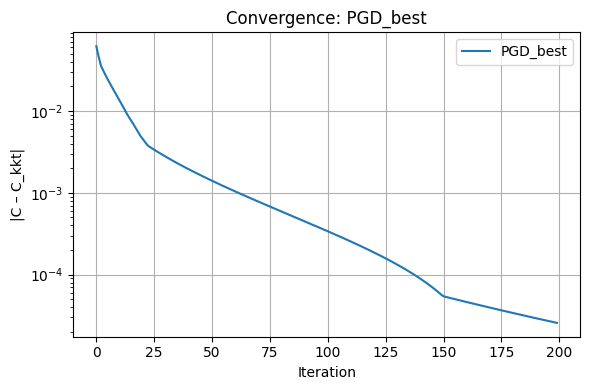

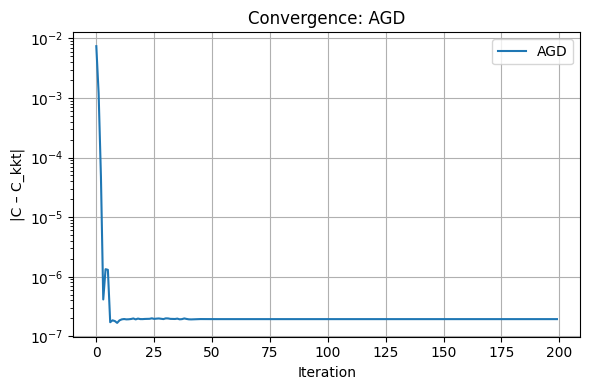

In [32]:
# Plot convergence for the three methods
for name, (_, errs) in results.items():
    plt.figure(figsize=(6,4))
    plt.plot(errs, label=name)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('|C – C_kkt|')
    plt.title(f'Convergence: {name}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

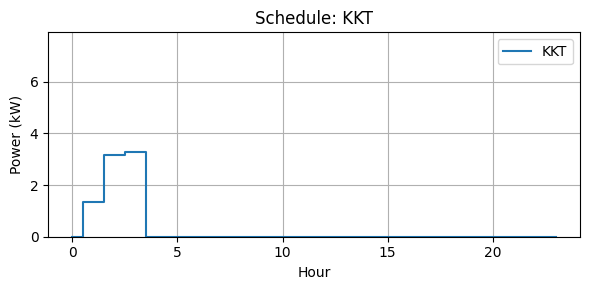

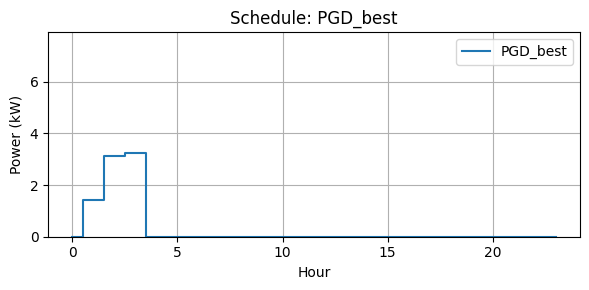

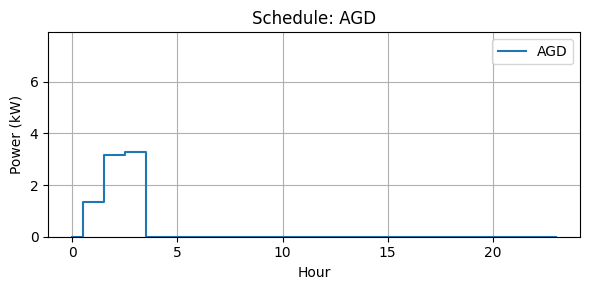

In [33]:
# Plot schedules for the three methods
hours = np.arange(24)
all_sched = {'KKT': x_kkt}
for name, (X, _) in results.items(): all_sched[name] = X
for name, X in all_sched.items():
    plt.figure(figsize=(6,3))
    plt.step(hours, X, where='mid', label=name)
    plt.xlabel('Hour'); plt.ylabel('Power (kW)')
    plt.title(f'Schedule: {name}')
    plt.ylim(0, P_max*1.1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()